In [18]:
# Start loading libraries

#! pip install yfinance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#! pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.model_selection import SlidingWindowForecastCV

import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from scipy.optimize import minimize
from random import gauss
import math
from statistics import mean, stdev

#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [19]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("FCPO") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df1 = df1.set_index(['Timestamp']) # use first column as index

#df1.to_excel("values.xlsx")  #print to excel



In [20]:
spot = df1["FCPOc1 USD"]
spot = np.log(spot)
spot = spot.loc['2004-01-31':'2022-11-30']
spot_train = spot.loc[:'2016-07-31']
#spot_train.plot()

In [21]:
# Load the data and split it into separate pieces
data = np.array(spot.dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

In [22]:
# Time series 1
model_1 = "OU" # "BS" = Brennan-Schwartz, "OU" = Ornestein-Uhlenbeck
sim_start_1 = "latest" # "beginning" = beginning of fit_date_range, "end" = end of fit_date_range, "latest" = last value in time series 
constrained_fit_1 = False # Constrain fit parameters mu within observed range


# Simulation paramaters
N_sims = 5000 # Number of simulations
N_points = 15 # How many points simulated *beyond* historical data

obs_1 = train

In [23]:
##### ORNSTEIN-UHLENBECK MODEL ##### From Neste
# One price iteration step
def OU_next(mu,sigma,kappa,x_prev,gen_rand=True,rand=None):
    if gen_rand:
        return x_prev + kappa*(mu-x_prev)+sigma*gauss(0,1)
    else:
        return x_prev + kappa*(mu-x_prev)+sigma*rand
# Simulate BS time series with parameters params = [mu,sigma,kappa], starting value x0 and N total simulation points
def OU_sim(params,x0,N,gen_rand=True,rands=None):
    mu = params[0]
    sigma = params[1]
    kappa = params[2]
    sim = [None]*N
    sim[0] = x0
    if gen_rand:
        for i in range(1,N):
            sim[i] = OU_next(mu,sigma,kappa,sim[i-1])
    else:
        for i in range(1,N):
            sim[i] = OU_next(mu,sigma,kappa,sim[i-1],False,rands[i])
    return sim
# Log-likelihood function for price change: x_prev -> x
def OU_LL(mu,sigma,kappa,x,x_prev):
    return 0.5*math.log(2*math.pi*(sigma)**2) + 0.5*((x-x_prev-kappa*(mu-x_prev))**2) / (sigma**2)
# Total log-likelihood value for simulation
def OU_LL_sim_1(params):
    mu = params[0]
    sigma = params[1]
    kappa = params[2]
    LL = [OU_LL(mu,sigma,kappa,obs_1[i],obs_1[i-1]) for i in range(1,len(obs_1))]
    return sum(LL)


In [24]:
##### SET SELECTED MODEL #####
if model_1 == "OU":
    LL_fun_1 = OU_LL_sim_1
    sim_fun_1 = OU_sim
    params0_1 = [mean(obs_1),stdev(obs_1),0.1] # Initial parameters for MLE optimizer
elif model_1 == "BS":
    LL_fun_1 = BS_LL_sim_1
    sim_fun_1 = BS_sim
    params0_1 = [mean(obs_1),stdev(obs_1)/mean(obs_1),0.1] # Initial parameters for MLE optimizer
else:
    raise ValueError("Model name \"" + "model" + "\" not valid!")


In [25]:
##### FIT MODEL 1 #####
print("\n##### FITTING MODELS #####")
print("\nFitting model 1 (\"" + model_1 + "\") using initial parameters:")
print("mu_0 = " + str(params0_1[0]))
print("sigma_0 = " + str(params0_1[1]))
print("kappa_0 = " + str(params0_1[2])+"")
if constrained_fit_1:
    print("NOTE: using constrained fit")
    # Constrain mu withing observed range
    res_1 = minimize(LL_fun_1,params0_1,bounds=[(min(obs_1),max(obs_1)),(None,None),(None,None)], method='L-BFGS-B') # Minimize LL function
else:
    res_1 = minimize(LL_fun_1,params0_1, method='L-BFGS-B') # Minimize LL function
if res_1.x[1] < 0:
    res_1.x[1] = -res_1.x[1]
##### PRINT RESULTS #####
print("Final fit parameters:")
print("mu = "+str(res_1.x[0]))
print("sigma = "+str(res_1.x[1]))
print("kappa = "+str(res_1.x[2]))
print("latest value (" + str(spot_train.index[-1]) + ") = " + str(spot_train[-1]))


##### FITTING MODELS #####

Fitting model 1 ("OU") using initial parameters:
mu_0 = 6.486398643617332
sigma_0 = 0.350372480566017
kappa_0 = 0.1
Final fit parameters:
mu = 6.528487307782921
sigma = 0.08605519112682954
kappa = 0.03320640535719802
latest value (2016-07-31 00:00:00) = 6.369425948244526


In [26]:
### Calculate sliding window one step ahead forecasts ###

insample = list(train)
predictions = []
paramsnew_1 = params0_1 #initial parameters

def OU_LL_sim_new(params):
    mu = params[0]
    sigma = params[1]
    kappa = params[2]
    LL = [OU_LL(mu,sigma,kappa,insample[i],insample[i-1]) for i in range(1,len(insample))]
    return sum(LL)

LL_fun_1 = OU_LL_sim_new

for i in range (len(test)):
    x_prev = insample[-1]
    res_1 = minimize(LL_fun_1,paramsnew_1, method='L-BFGS-B') # Minimize LL function
    nextstep = x_prev + res_1.x[2]*(res_1.x[0]-x_prev)
    predictions.append(nextstep)
    insample.pop(0)
    insample.append(test[i])

    paramsnew_1 = [mean(insample),stdev(insample)/mean(insample),0.1] # new initial parameters

In [27]:
def smape_kun(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))*100

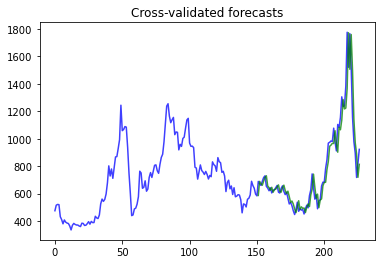

In [28]:
exp_predictions = np.exp(predictions)
exp_spot= np.exp(spot)
exp_test = np.exp(test)
exp_train = np.exp(train)

x_axis = np.arange(exp_spot.shape[0])
n_test = exp_predictions.shape[0]

plt.plot(x_axis, exp_spot, alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], exp_predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated forecasts")
plt.show()

In [29]:
error = mean_squared_error(exp_test, exp_predictions)
print('Mean Squared Error: %.3f' % error)
error2 = mean_absolute_error(exp_test, exp_predictions)
print('Mean Absolute Error: %.3f' % error2)
error3 = mean_absolute_percentage_error(exp_test, exp_predictions)
print('Mean Absolute Percentage Error: %.3f' % (error3*100))
error4 = smape_kun(exp_test, exp_predictions)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error4)

Mean Squared Error: 10987.543
Mean Absolute Error: 69.560
Mean Absolute Percentage Error: 8.086
Symmetric Mean Absolute Percentage Error: 8.054


In [30]:
### same with built-in function ###

#predictions22 = model_selection.cross_val_score(
#    ar, spot, scoring='mean_absolute_error', cv=cv, verbose=0)
#np.average(predictions22)

In [31]:
#### MASE ###

abs_errors = abs(exp_predictions - exp_test)
mae_naive_list = []

for x in range(len(exp_test)):
    insample_data = exp_spot[x:-(len(exp_test)-x)]
    mae_insample = np.mean(abs(insample_data.diff().dropna()))
    mae_naive_list.append(mae_insample)

mase = np.mean(abs_errors / mae_naive_list)

print('Mean Absolute Scaled Error: %.3f' % mase)

Mean Absolute Scaled Error: 1.451


In [32]:
### Returns ###

returns = []

test_app2 = list(exp_test)
test_app2.insert(0, exp_train[-1]) ## append last of train data
price_moves = np.array(pd.DataFrame(test_app2).pct_change().dropna()+1)

pred_app2 = list(predictions)

test_shift2 = list(test)
test_shift2.insert(0, train[-1])
test_shift2.pop()

dir_pred2 = np.array(np.sign([a - b for a, b in zip(pred_app2,test_shift2)]))

for t in range(len(dir_pred2)):
    if dir_pred2[t] == 1:
            returns.append(price_moves[t])
        
    if dir_pred2[t] == -1:
        returns.append(1/price_moves[t])

returns = pd.DataFrame(returns)
returns


,0
0,1.180325
1,0.974753
2,0.982248
3,1.046609
4,1.039354
...,...
71,1.179449
72,1.094293
73,1.246484
74,1.137275


In [33]:
### Returns t-test ###

t_statistic, p_value = stats.ttest_1samp(a=returns, popmean=1, alternative='greater') ### one tailed test?


print(t_statistic , p_value)

[0.88032821] [0.19074688]


In [34]:
### Merton test ###

test_app = list(test)
test_app.insert(0, train[-1]) ## append last of train data
dir = np.array(np.sign(pd.DataFrame(test_app).diff().dropna()))

pred_app = list(predictions)

test_shift = list(test)
test_shift.insert(0, train[-1])
test_shift.pop()

dir_pred = np.array(np.sign([a - b for a, b in zip(pred_app,test_shift)]))

q_minus = 0
q_plus = 0
pred_minus = 0
pred_plus = 0

for t in range(len(dir)):
    if dir[t] == 1:
        q_plus += 1
        if dir_pred[t] == 1:
            pred_plus += 1
    if dir[t] == -1:
        q_minus += 1
        if dir_pred[t] == -1:
            pred_minus += 1

print('Merton test: %.3f' % ((pred_plus / q_plus) + (pred_minus / q_minus)))

Merton test: 1.015
